# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import scienceplots
import seaborn

plt.style.use(["science", "no-latex"])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")
import numpy as np
import torch
from sklearn import datasets, decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    DenseEncoder,
    MinMaxScalerTorch,
    StandardScalerTorch,
)

In [4]:
import polcanet.polcanet_reports as report

In [5]:
np.random.seed(1)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load iris dataset

In [7]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X.shape, X[0].shape

((150, 4), (4,))

### Fit standard sklearn PCA

In [8]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
Xpca = pca.transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

### Fit POLCANet

In [99]:
ae_input = X
act_fn = torch.nn.SiLU
input_dim = (ae_input.shape[1],)
latent_dim = 4

encoder_iris = DenseEncoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    num_layers=5,
    act_fn=act_fn,
    first_layer_size= 256,
    # hidden_size=256,
)

decoder_iris = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=256,
    num_layers=3,
    act_fn=torch.nn.Tanh,
)


model_iris = PolcaNet(
    encoder=encoder_iris,
    decoder=decoder_iris,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler = StandardScalerTorch(),
)
model_iris

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): DenseEncoder(
        (encoder): Sequential(
          (0): Linear(in_features=4, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=214, bias=True)
          (3): SiLU()
          (4): Linear(in_features=214, out_features=172, bias=True)
          (5): SiLU()
          (6): Linear(in_features=172, out_features=130, bias=True)
          (7): SiLU()
          (8): Linear(in_features=130, out_features=88, bias=True)
          (9): SiLU()
          (10): Linear(in_features=88, out_features=46, bias=True)
          (11): SiLU()
          (12): Linear(in_features=46, out_features=4, bias=True)
        )
      )
      (1): Tanh()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Tanh()
      (4): L

In [100]:
model_iris.to("cuda")
model_iris.train_model(
    data=X, batch_size=512, num_epochs=10000, report_freq=100, lr=1e-3
)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.04449
Reconstruction Loss: 0.0005201
Orthogonality Loss: 0.002209
Center of Mass Loss: 0.02327
Variance Distribution Loss: 0.0197


0.044494710862636566

In [101]:
model_iris.train_model(
    data=X, batch_size=512, num_epochs=10000, report_freq=100, lr=1e-4
)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.04274
Reconstruction Loss: 1.487e-05
Orthogonality Loss: 0.0001371
Center of Mass Loss: 0.02209
Variance Distribution Loss: 0.0204


0.04273858666419983

In [102]:
model_iris.train_model(
    data=X, batch_size=512, num_epochs=10000, report_freq=100, lr=1e-5
)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.04263
Reconstruction Loss: 1.384e-06
Orthogonality Loss: 2.701e-07
Center of Mass Loss: 0.02203
Variance Distribution Loss: 0.02043


0.04262816905975342

## Evaluate results

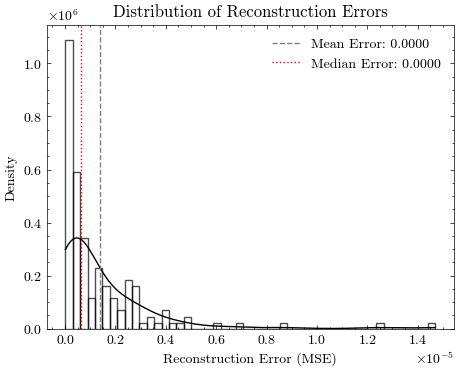

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0000


In [103]:
report.analyze_reconstruction_error(model_iris, X)

In [104]:
latents, reconstructed = model_iris.predict(X)

In [105]:
report.analyze_latent_space(model_iris, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 4
Total variance in latent space: 0.0007

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.6515
First 5 components              1
Components for 95% variance     2
Variance Concentration Metric   0.9126

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0293
Median absolute off-diagonal          0.005
Max absolute off-diagonal             0.137
Proportion of |Orthogonality| > 0.1   0.1667
Orthogonality Success Metric          0.9707

Orthogonality Interpretation:
Excellent orthogonality of features.

4. Deta


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 150 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0003
    - Max cosine similarity: 0.0012
    - Min cosine similarity: -0.0002
    


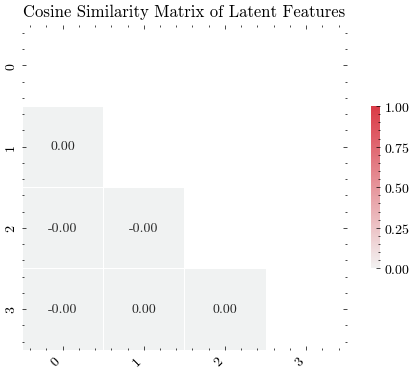

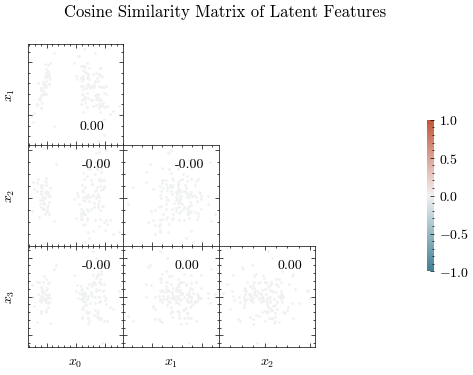

In [106]:
report.orthogonality_test_analysis(model_iris, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 150 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.3497
    - Variance fit to exponential distribution (sum of squared differences):
     0.0208
    


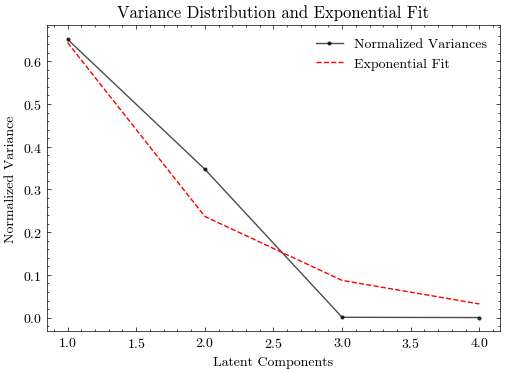

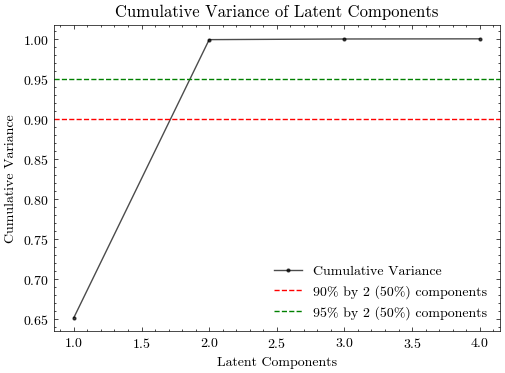

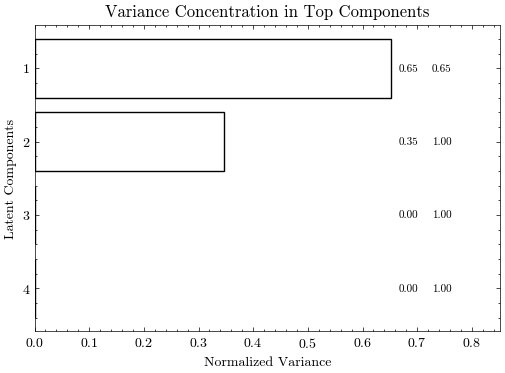

In [107]:
report.variance_test_analysis(model_iris, X)

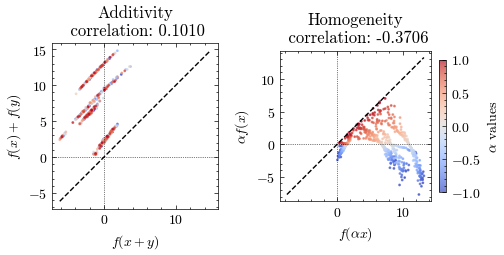

In [108]:
report.linearity_tests_analysis(model_iris, X)

## Polca Net vs. PCA

In [109]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
        ax.scatter(X[y == label, 0], X[y == label, 1], label=name)
        ax.set_xlabel("component 0")
        ax.set_ylabel("component 1")
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [110]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _, _ = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [111]:
o1 = widgets.Output()
o2 = widgets.Output()
o3 = widgets.Output()
o4 = widgets.Output()

with o1:
    fig1, ax1 = plot2d_analysis(X, y, "Original data two first componets", legend=False)

with o2:
    latents, reconstructed = model_iris.predict(X, np.ones(latent_dim))
    fig2, ax2 = plot2d_analysis(
        np.round(reconstructed, 1),
        y,
        title="Reconstructed with POLCA all componets",
        legend=False,
    )

with o3:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 0, 0]))
    fig3, ax3 = plot2d_analysis(
        np.round(reconstructed, 1),
        y,
        title="Reconstructed with POLCA two componets",
        legend=False,
    )

with o4:
    fig4, ax4 = plot2d_analysis(
        np.round(pca.inverse_transform(Xpca), 1),
        y,
        "Reconstructed with PCA two componets",
        legend=False,
    )


layout = widgets.Layout(grid_template_columns="repeat(2, 450px)")
accordion = widgets.GridBox(children=[o1, o2, o3, o4], layout=layout)
display(accordion)

GridBox(children=(Output(), Output(), Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 450p…

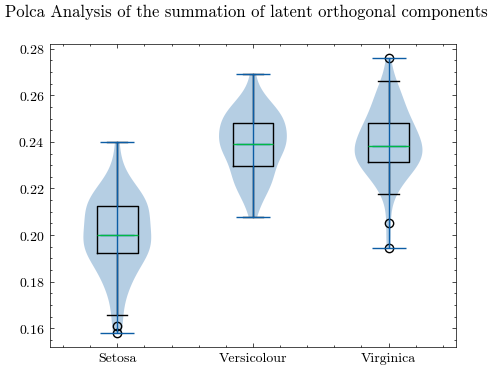

In [112]:
latents, reconstructed = model_iris.predict(X)
vectors = []
labels = ["Setosa", "Versicolour", "Virginica"]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [113]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model_iris.score(X)
    sns.displot(scores, kde=True, fill=False, color="black")
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model_iris.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True, fill=False, color="black")
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [114]:
model_iris.std_metrics

tensor([0.0208, 0.0152, 0.0007, 0.0004], device='cuda:0')

In [115]:
model_iris.mean_metrics

tensor([ 1.9151e-04,  2.2589e-01, -1.3399e-06,  4.1481e-07], device='cuda:0')

## Test Classification with two components on PCA vs POLCA Net

In [116]:
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [117]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [118]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((105, 2), (45, 2))

In [119]:
# Transform the data using POLCA-Net
X_train_polca = model_iris.predict(X_train, np.array([1, 1, 0, 0]))[0][:, :2]
#X_train_polca = model_iris.predict(X_trai)[0][:, :pca.n_components]
X_test_polca = model_iris.predict(X_test, np.array([1, 1, 0, 0]))[0][:, :2]
#X_test_polca = model_iris.predict(X_test)[0][:, :pca.n_components]
X_train_polca.shape, X_test_polca.shape

((105, 2), (45, 2))

In [120]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": SVC(kernel="linear", probability=True),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(),
}

In [121]:
# Train and evaluate classifiers on both PCA and POLCA-Net transformed datasets
results = []

for name, clf in classifiers.items():
    # Train on PCA
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    report_pca = classification_report(y_test, y_pred_pca, output_dict=True)

    # Train on POLCA-Net
    clf.fit(X_train_polca, y_train)
    y_pred_polca = clf.predict(X_test_polca)
    accuracy_polca = accuracy_score(y_test, y_pred_polca)
    report_polca = classification_report(y_test, y_pred_polca, output_dict=True)

    # Append results
    results.append(
        {
            "Classifier": name,
            "Transformation": "PCA",
            "Accuracy": accuracy_pca,
            "Precision": report_pca["weighted avg"]["precision"],
            "Recall": report_pca["weighted avg"]["recall"],
            "F1-Score": report_pca["weighted avg"]["f1-score"],
        }
    )

    results.append(
        {
            "Classifier": name,
            "Transformation": "POLCA-Net",
            "Accuracy": accuracy_polca,
            "Precision": report_polca["weighted avg"]["precision"],
            "Recall": report_polca["weighted avg"]["recall"],
            "F1-Score": report_polca["weighted avg"]["f1-score"],
        }
    )

/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [122]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df

,Classifier,Transformation,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,PCA,0.977778,0.979365,0.977778,0.977872
1,Logistic Regression,POLCA-Net,0.600000,0.432258,0.600000,0.481818
2,Gaussian Naive Bayes,PCA,0.933333,0.935201,0.933333,0.933616
3,Gaussian Naive Bayes,POLCA-Net,0.977778,0.979365,0.977778,0.977872
4,Linear SVM,PCA,0.977778,0.979365,0.977778,0.977872
5,Linear SVM,POLCA-Net,0.288889,0.083457,0.288889,0.129502
6,Ridge Classifier,PCA,0.755556,0.824242,0.755556,0.746243
7,Ridge Classifier,POLCA-Net,0.600000,0.415556,0.600000,0.475060
8,Perceptron,PCA,0.955556,0.960000,0.955556,0.954873
9,Perceptron,POLCA-Net,0.400000,0.160000,0.400000,0.228571


In [34]:
# Statistical test: Paired t-test for accuracies
comparison_metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
print(f"\nPaired t-test results:")
for comparison_metric in comparison_metrics:

    print(f"{comparison_metric}:")
    pca_result = results_df[results_df["Transformation"] == "PCA"][comparison_metric]
    polca_result = results_df[results_df["Transformation"] == "POLCA-Net"][
        comparison_metric
    ]
    t_stat, p_value = ttest_rel(pca_result.values, polca_result.values)
    print(f"\tt-statistic = {t_stat}, p-value = {p_value}, p-value threshold < {0.05}")
    if p_value < 0.05:
        # print(f"There is a statistically significant difference between the PCA and POLCA-Net transformations")
        ans = "a"
    else:
        ans = "no"

    print(
        f"\tThere is {ans} statistically significant difference between the PCA and POLCA-Net transformations."
    )


Paired t-test results:
Accuracy:
	t-statistic = 2.5195169653642004, p-value = 0.06539041718698413, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
Precision:
	t-statistic = 3.0220862550692122, p-value = 0.03908303745546725, p-value threshold < 0.05
	There is a statistically significant difference between the PCA and POLCA-Net transformations.
Recall:
	t-statistic = 2.5195169653642004, p-value = 0.06539041718698413, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
F1-Score:
	t-statistic = 2.766112514091557, p-value = 0.05053188487011021, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
